<a href="https://colab.research.google.com/github/andre-la-machado/cnr/blob/master/modelling_lstm_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Modelling

On this Notebook, a LSTM Model will be tried for the Competitition Data.

## Libraries

In [2]:
%pip uninstall -q -y tensorflow
%pip install -q -U tensorflow-gpu>=2
%reset -f

In [3]:
!nvidia-smi

Sun Sep 27 13:48:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style('darkgrid')
from cnr_methods import get_selected_features, transform_data, revert_data, get_simplified_data
import random

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())  # Sanity check: GPU available to tf or not
print(tf.test.is_built_with_gpu_support())
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)  # Check if __version__>="2.0.0"
print(tf.keras.__version__)

True
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.3.1
2.4.0


## Read Data

Here, the data used correspond to the results of the Feature Engineering and Selection Step. For simplicity, during Hyperparameter Optimization, only Wind Farm 3 Training Data is used.

In [6]:
full_data = pd.read_csv("Selected_Features_Data.csv")

#full_data = full_data.rename({'Unnamed: 0' : 'Time'},axis=1)
full_data = full_data.set_index('Time')

full_label = pd.read_csv('Y_train.csv')
X = full_data[full_data['Set']=='Train']

WF = 'WF3'
X = X[X['WF']==WF]
y = full_label[full_label['ID'].isin(X['ID'])]

In [7]:
X.head()

,ID,WF,U_100m,V_100m,U_10m,V_10m,T,CLCT,Set,Wind Speed 100m,Wind Direction 100m,Wind Speed 10m,Wind Direction 10m,T_lag_7_days,T_lag_14_days,T_lag_21_days,CLCT_lag_7_days,CLCT_lag_14_days,CLCT_lag_21_days,U_100m_lag_7_days,U_100m_lag_14_days,U_100m_lag_21_days,V_100m_lag_7_days,V_100m_lag_14_days,V_100m_lag_21_days,U_10m_lag_7_days,U_10m_lag_14_days,U_10m_lag_21_days,V_10m_lag_7_days,V_10m_lag_14_days,V_10m_lag_21_days,Month_Number,T_Last_Month_Mean,CLCT_Last_Month_Mean,U_100m_Last_Month_Mean,V_100m_Last_Month_Mean,U_10m_Last_Month_Mean,V_10m_Last_Month_Mean,TLast_Month_Variance,CLCTLast_Month_Variance,...,CLCT_Distance_Max,CLCT_Distance_Min,U_100m_Distance_Max,U_100m_Distance_Min,V_100m_Distance_Max,V_100m_Distance_Min,U_10m_Distance_Max,U_10m_Distance_Min,V_10m_Distance_Max,V_10m_Distance_Min,T_Rolling_7_Window_Mean,T_Rolling_14_Window_Mean,T_Rolling_7_Window_Variance,T_Rolling_14_Window_Variance,CLCT_Rolling_7_Window_Mean,CLCT_Rolling_14_Window_Mean,CLCT_Rolling_7_Window_Variance,CLCT_Rolling_14_Window_Variance,U_100m_Rolling_7_Window_Mean,U_100m_Rolling_14_Window_Mean,U_100m_Rolling_7_Window_Variance,U_100m_Rolling_14_Window_Variance,V_100m_Rolling_7_Window_Mean,V_100m_Rolling_14_Window_Mean,V_100m_Rolling_7_Window_Variance,V_100m_Rolling_14_Window_Variance,U_10m_Rolling_7_Window_Mean,U_10m_Rolling_14_Window_Mean,U_10m_Rolling_7_Window_Variance,U_10m_Rolling_14_Window_Variance,V_10m_Rolling_7_Window_Mean,V_10m_Rolling_14_Window_Mean,V_10m_Rolling_7_Window_Variance,V_10m_Rolling_14_Window_Variance,T_Expanded_Window_Max,CLCT_Expanded_Window_Max,U_100m_Expanded_Window_Max,V_100m_Expanded_Window_Max,U_10m_Expanded_Window_Max,V_10m_Expanded_Window_Max
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-05-01 01:00:00,12479,WF3,5.789500,3.820200,1.054669,1.317597,275.690,86.504507,Train,6.936299,0.583268,1.687717,0.895782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275.690,86.504507,5.7895,3.8202,1.054669,1.317597
2018-05-01 02:00:00,12480,WF3,6.003300,3.920600,0.876879,1.483483,275.770,98.976088,Train,7.170127,0.578533,1.723264,1.036951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275.770,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 03:00:00,12481,WF3,5.931829,0.907656,0.949640,1.419591,276.875,64.193607,Train,6.000870,0.151837,1.707938,0.981212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 04:00:00,12482,WF3,5.205300,1.683800,1.027462,1.029786,275.650,57.482484,Train,5.470862,0.312855,1.454695,0.786528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 05:00:00,12483,WF3,4.845900,0.702200,1.011645,0.785352,275.530,89.971463,Train,4.896512,0.143904,1.280704,0.660129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-159,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483


## Scaling Data

For a better performance of the Network, here the data is scaled between [-1,1] using MinMaxScaler. For the Direction Data, presented in degrees, Sin and Cos are calculated, which naturally have values in this same scale.

In [8]:
def preprocessing_X(X):

  scaler = MinMaxScaler(feature_range=(-1,1))

  X_saved_columns = X[['ID','WF','Set','Month_Number']]
  X_saved_columns = X_saved_columns.reset_index().drop('Time',axis=1)
  X = X.drop(['ID','WF','Set','Month_Number'],axis=1)

  # Fill NaN's
  #X = X.fillna(method="ffill", axis=1) # ZOH
  #X = X.fillna(0)

  # Scaling Data
  directions = X[['Wind Direction 100m', 'Wind Direction 10m']]
  directions["Sin_Wind Direction 100m"] = np.sin(X['Wind Direction 100m']*(np.pi/180))
  directions["Cos_Wind Direction 100m"] = np.cos(X['Wind Direction 100m']*(np.pi/180))
  directions["Sin_Wind Direction 10m"] = np.sin(X['Wind Direction 10m']*(np.pi/180))
  directions["Cos_Wind Direction 10m"] = np.cos(X['Wind Direction 10m']*(np.pi/180))
  directions = directions.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
  directions = directions.reset_index().drop('Time',axis=1)

  X = X.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
  X_columns = X.columns

  X = scaler.fit_transform(X)
  X = pd.DataFrame(X,columns=X_columns)
  X = pd.concat([X,directions],axis=1)
  X = pd.concat([X,X_saved_columns],axis=1)

  X = X.fillna(-2)

  return X

In [9]:
def preprocessing_y(y):

  scaler = MinMaxScaler(feature_range=(-1,1))

  #y = y.fillna(method="ffill", axis=1) # ZOH
  #y = y.fillna(0)
  y = y.drop('ID',axis=1)
  y = scaler.fit_transform(y)
  y = pd.DataFrame(y)
  y = y.fillna(-2)

  return y,scaler

In [10]:
y.shape

(6239, 2)

## Subsets Creation

Here, the Data is converted to a group of subsets where each subset has n_steps of past data.

In [11]:
n_steps = 30

In [12]:
# split a multivariate sequence into samples
def split_sequences(X, y = None, n_steps = 1):
	sample_X, sample_y = list(), list()
	for i in range(len(X)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(X):
			break
		# gather input and output parts of the pattern
		seq_x = X[i:end_ix, :]
		sample_X.append(seq_x)
		if y is not None:
			seq_y = y[end_ix-1,-1]
			sample_y.append(seq_y)
	return np.array(sample_X), np.array(sample_y)

In [13]:
def shift_save(df,n_steps):
  empty = pd.DataFrame(np.zeros((n_steps-1,df.shape[1])),columns=df.columns)
  df = pd.concat([empty,df])
  return df

In [14]:
sample_X,sample_y = split_sequences(X.values,y.values,n_steps)

In [15]:
n_features = sample_X.shape[2] - 2

## Model

Here, a function to create the Model usin Keras is defined.

In [16]:
def LSTM_Model(input_shape, batch_size=1):
  # Numerical branch

  input_layer = tf.keras.Input(shape = input_shape,batch_size = batch_size)

  hidden_1 = tf.keras.layers.LSTM(units=128,return_sequences=True,stateful=True)(input_layer)
  hidden_1 = tf.keras.layers.Dropout(0.4)(hidden_1)

  hidden_2 = tf.keras.layers.LSTM(units=87,return_sequences=True,stateful=True)(hidden_1)
  hidden_2 = tf.keras.layers.Dropout(0.4)(hidden_2)

  hidden_3 = tf.keras.layers.LSTM(units=57,stateful=True)(hidden_2)
  hidden_3 = tf.keras.layers.Dropout(0.4)(hidden_3)

  # Output
  #outputs = tf.keras.layers.PReLU()(hidden_2)
  #outputs = tf.keras.layers.Dropout(rate=0.2)(hidden_2)
  outputs = tf.keras.layers.Dense(units=1)(hidden_3)

  model = tf.keras.Model(inputs=input_layer, outputs=outputs)

  return model

In [17]:
input_shape = (n_steps,n_features)

In [18]:
model = LSTM_Model(input_shape)

In [19]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1, 30, 94)]             0         
_________________________________________________________________
lstm (LSTM)                  (1, 30, 128)              114176    
_________________________________________________________________
dropout (Dropout)            (1, 30, 128)              0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 30, 87)               75168     
_________________________________________________________________
dropout_1 (Dropout)          (1, 30, 87)               0         
_________________________________________________________________
lstm_2 (LSTM)                (1, 57)                   33060     
_________________________________________________________________
dropout_2 (Dropout)          (1, 57)                  

## Validation

In [20]:
random.seed(317)
tf.random.set_seed(317)

patience = 3
epochs = 10
k_fold_splits = 5
total_it = 50
monitor = "root_mean_squared_error"
batch_size = 1

In [21]:
# Define Time Split Cross Validation
tscv = TimeSeriesSplit(n_splits=k_fold_splits)

# Separating Data from Hold Out Set

X_cv, _, y_cv, _ = train_test_split(X, y, test_size=0.125, shuffle=False)

train_scores = np.empty(0)
val_scores = np.empty(0)
test_scores = np.empty(0)
for train_index, test_index in tscv.split(X_cv):

    #train_index = train_index[-n_rows:]
    #test_index = test_index[-n_rows:]

    # Get the Data of the Split
    X_train, X_test = X_cv.iloc[train_index], X_cv.iloc[test_index]
    y_train, y_test = y_cv.iloc[train_index], y_cv.iloc[test_index]

    # Separating Training Set of Split on Train and Validation Subsets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

    # Preprocessing Data
    X_train = preprocessing_X(X_train)
    X_val = preprocessing_X(X_val)
    X_test = preprocessing_X(X_test)

    X_train = X_train.drop(['ID','WF','Set','Month_Number'],axis=1)
    X_val = X_val.drop(['ID','WF','Set','Month_Number'],axis=1)
    X_test = X_test.drop(['ID','WF','Set','Month_Number'],axis=1)

    y_train,_ = preprocessing_y(y_train)
    y_val,_ = preprocessing_y(y_val)
    y_test,_ = preprocessing_y(y_test)

    # Reshape Data
    X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
    X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
    X_test, y_test = split_sequences(X_test.values,y_test.values,n_steps)

    # Create Model
    model = LSTM_Model(input_shape,batch_size=batch_size)

    # Callbacks
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]

    # Train the Model
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    history = model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

    # Train and Validation Score
    train_score = np.array(history.history['root_mean_squared_error']).mean()
    val_score = np.array(history.history['val_root_mean_squared_error']).mean()

    # Test Score
    preds = model.predict(X_test,batch_size = batch_size,callbacks=callbacks_list)
    preds = tf.cast(preds, tf.float32)
    y_test = tf.cast(y_test, tf.float32)

    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(y_test,preds)
    test_score = m.result().numpy()

    train_scores = np.append(train_scores,train_score)
    val_scores = np.append(val_scores,val_score)
    test_scores = np.append(test_scores,test_score)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
754/754 [==============================] - 6s 8ms/step - loss: 0.1536 - root_mean_squared_error: 0.3919 - val_loss: 0.2144 - val_root_mean_squared_error: 0.4631
Epoch 2/10
754/754 [==============================] - 5s 7ms/step - loss: 0.1524 - root_mean_squared_error: 0.3904 - val_loss: 0.1942 - val_root_mean_squared_error: 0.4407
Epoch 3/10
754/754 [==============================] - 5s 7ms/step - loss: 0.1482 - root_mean_squared_error: 0.3849 - val_loss: 0.1868 - val_root_mean_squared_error: 0.4323
Epoch 4/10
754/754 [==============================] - 6s 7ms/step - loss: 0.1429 - root_mean_squared_error: 0.3781 - val_loss: 0.1761 - val_root_mean_squared_error: 0.4196
Epoch 5/10
754/754 [==============================] - 6s 7ms/step - loss: 0.1377 - root_mean_squared_error: 0.3711 - val_loss: 0.1064 - val_root_mean_squared_error: 0.3262
Epoch 6/10
754/754 [==============================] - 6s 7ms/step - loss: 0.1280 - root_mean_squared_error: 0.3578 - val_loss: 0.1124 - val_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
1533/1533 [==============================] - 12s 8ms/step - loss: 0.1191 - root_mean_squared_error: 0.3452 - val_loss: 0.2268 - val_root_mean_squared_error: 0.4762
Epoch 2/10
1533/1533 [==============================] - 11s 7ms/step - loss: 0.1133 - root_mean_squared_error: 0.3367 - val_loss: 0.2100 - val_root_mean_squared_error: 0.4583
Epoch 3/10
1533/1533 [==============================] - 11s 7ms/step - loss: 0.1105 - root_mean_squared_error: 0.3324 - val_loss: 0.1740 - val_root_mean_squared_error: 0.4171
Epoch 4/10
1533/1533 [==============================] - 11s 7ms/step - loss: 0.1077 - root_mean_squared_error: 0.3282 - val_loss: 0.2105 - val_root_mean_squared_error: 0.4588
Epoch 5/10
1533/1533 [==============================] - 11s 7ms/step - loss: 0.1056 - root_mean_squared_error: 0.3249 - val_loss: 0.2165 - val_root_mean_squared_error: 0.4653
Epoch 6/10
1533/1533 [==============================] - 11s 7ms/step - loss: 0.1046 - root_mean_squared_error: 0.3235 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
2312/2312 [==============================] - 18s 8ms/step - loss: 0.1166 - root_mean_squared_error: 0.3414 - val_loss: 0.1303 - val_root_mean_squared_error: 0.3610
Epoch 2/10
2312/2312 [==============================] - 18s 8ms/step - loss: 0.1091 - root_mean_squared_error: 0.3304 - val_loss: 0.1374 - val_root_mean_squared_error: 0.3707
Epoch 3/10
2312/2312 [==============================] - 18s 8ms/step - loss: 0.0999 - root_mean_squared_error: 0.3161 - val_loss: 0.1514 - val_root_mean_squared_error: 0.3891
Epoch 4/10
2312/2312 [==============================] - 17s 8ms/step - loss: 0.0891 - root_mean_squared_error: 0.2984 - val_loss: 0.1493 - val_root_mean_squared_error: 0.3864
Epoch 5/10
2312/2312 [==============================] - 17s 7ms/step - loss: 0.0820 - root_mean_squared_error: 0.2864 - val_loss: 0.1207 - val_root_mean_squared_error: 0.3474
Epoch 6/10
2312/2312 [==============================] - 18s 8ms/step - loss: 0.0712 - root_mean_squared_error: 0.2668 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
3091/3091 [==============================] - 24s 8ms/step - loss: 0.1139 - root_mean_squared_error: 0.3375 - val_loss: 0.1745 - val_root_mean_squared_error: 0.4177
Epoch 2/10
3091/3091 [==============================] - 23s 7ms/step - loss: 0.1039 - root_mean_squared_error: 0.3223 - val_loss: 0.1680 - val_root_mean_squared_error: 0.4098
Epoch 3/10
3091/3091 [==============================] - 23s 7ms/step - loss: 0.0944 - root_mean_squared_error: 0.3073 - val_loss: 0.1151 - val_root_mean_squared_error: 0.3392
Epoch 4/10
3091/3091 [==============================] - 23s 7ms/step - loss: 0.0849 - root_mean_squared_error: 0.2913 - val_loss: 0.1260 - val_root_mean_squared_error: 0.3550
Epoch 5/10
3091/3091 [==============================] - 23s 7ms/step - loss: 0.0747 - root_mean_squared_error: 0.2733 - val_loss: 0.1157 - val_root_mean_squared_error: 0.3401
Epoch 6/10
3091/3091 [==============================] - 23s 7ms/step - loss: 0.0640 - root_mean_squared_error: 0.2529 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
3870/3870 [==============================] - 30s 8ms/step - loss: 0.0868 - root_mean_squared_error: 0.2946 - val_loss: 0.1552 - val_root_mean_squared_error: 0.3940
Epoch 2/10
3870/3870 [==============================] - 29s 7ms/step - loss: 0.0799 - root_mean_squared_error: 0.2826 - val_loss: 0.1446 - val_root_mean_squared_error: 0.3803
Epoch 3/10
3870/3870 [==============================] - 28s 7ms/step - loss: 0.0702 - root_mean_squared_error: 0.2650 - val_loss: 0.1343 - val_root_mean_squared_error: 0.3664
Epoch 4/10
3870/3870 [==============================] - 29s 8ms/step - loss: 0.0583 - root_mean_squared_error: 0.2415 - val_loss: 0.0957 - val_root_mean_squared_error: 0.3094
Epoch 5/10
3870/3870 [==============================] - 28s 7ms/step - loss: 0.0482 - root_mean_squared_error: 0.2194 - val_loss: 0.0848 - val_root_mean_squared_error: 0.2912
Epoch 6/10
3870/3870 [==============================] - 29s 7ms/step - loss: 0.0369 - root_mean_squared_error: 0.1921 - val_l

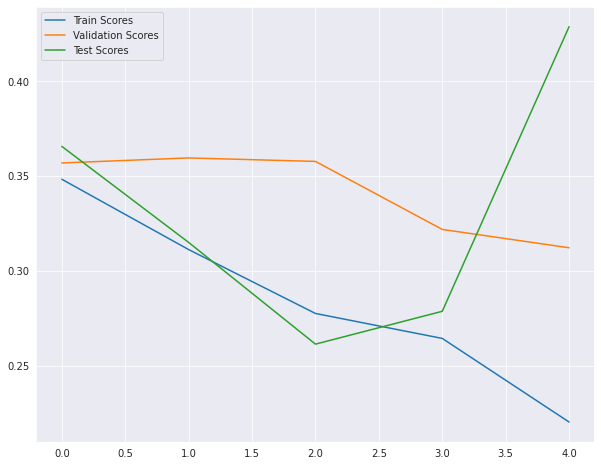

In [22]:
plt.figure(figsize=(10,8))
plt.plot(range(len(train_scores)),train_scores,label='Train Scores')
plt.plot(range(len(val_scores)),val_scores,label='Validation Scores')
plt.plot(range(len(test_scores)),test_scores,label='Test Scores')
plt.legend()

### Hold Out Score

Here, the same model is trained on all the data used on the Validation and tested on a Holdout Set never seen before.

In [23]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.125, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

In [24]:
X_train = preprocessing_X(X_train)
X_val = preprocessing_X(X_val)
X_holdout = preprocessing_X(X_holdout)

X_train = X_train.drop(['ID','WF','Set','Month_Number'],axis=1)
X_val = X_val.drop(['ID','WF','Set','Month_Number'],axis=1)
X_holdout = X_holdout.drop(['ID','WF','Set','Month_Number'],axis=1)

y_train,scaler = preprocessing_y(y_train)
y_val,_ = preprocessing_y(y_val)
y_holdout,_ = preprocessing_y(y_holdout)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [25]:
X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
X_holdout, y_holdout = split_sequences(X_holdout.values,y_holdout.values,n_steps)

In [26]:
model = LSTM_Model(input_shape)

In [27]:
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list)

Epoch 1/10
4649/4649 [==============================] - 36s 8ms/step - loss: 0.0817 - root_mean_squared_error: 0.2859 - val_loss: 0.1622 - val_root_mean_squared_error: 0.4027
Epoch 2/10
4649/4649 [==============================] - 35s 8ms/step - loss: 0.0421 - root_mean_squared_error: 0.2052 - val_loss: 0.0812 - val_root_mean_squared_error: 0.2850
Epoch 3/10
4649/4649 [==============================] - 34s 7ms/step - loss: 0.0352 - root_mean_squared_error: 0.1875 - val_loss: 0.1145 - val_root_mean_squared_error: 0.3384
Epoch 4/10
4649/4649 [==============================] - 34s 7ms/step - loss: 0.0302 - root_mean_squared_error: 0.1737 - val_loss: 0.0997 - val_root_mean_squared_error: 0.3158
Epoch 5/10
4649/4649 [==============================] - 35s 8ms/step - loss: 0.0275 - root_mean_squared_error: 0.1659 - val_loss: 0.1103 - val_root_mean_squared_error: 0.3322
Epoch 6/10
4649/4649 [==============================] - 34s 7ms/step - loss: 0.0278 - root_mean_squared_error: 0.1667 - val_l

In [28]:
preds = model.predict(X_holdout,batch_size = batch_size,callbacks=callbacks_list)

Here, Predicitions and True Labels of the Holdout Set are scaled back to measure the CAPE Error, and be compared on a Chart.

In [29]:
preds = scaler.inverse_transform(preds)
y_holdout = scaler.inverse_transform(pd.DataFrame(y_holdout))

In [30]:
def metric_cnr(preds,labels):
    cape_cnr = 100*np.sum(np.abs(preds-labels))/np.sum(labels)
    return 'CAPE', cape_cnr

In [31]:
metric_cnr(preds,y_holdout)

('CAPE', 43.69522777664263)

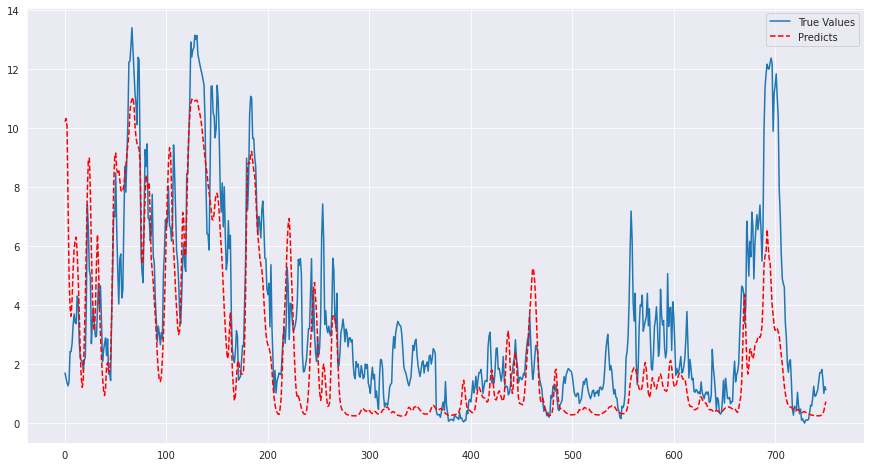

In [32]:
plt.figure(figsize=(15,8))
preds_len = np.arange(len(y_holdout))
plt.plot(preds_len,y_holdout,label='True Values')
plt.plot(preds_len,preds,'r--',label='Predicts')
plt.legend()

## Submission Generation

First, a function with all the preprocessing made to prepare data for network is defined.

Here's a Function with all the Process of Submit Gen for One Wind Farm. This Model is the Standard:

In [33]:
def WF_submit_gen(full_data,full_label,WF,input_shape,batch_size):
  # Get Data of Wind Farm
  X_WF = full_data[full_data['WF']==WF]

  # Scale X Data
  X_WF = preprocessing_X(X_WF)

  full_X_train = X_WF[X_WF['Set']=='Train']
  full_X_test = X_WF[X_WF['Set']=='Test']
  full_y_train = full_label[full_label['ID'].isin(full_X_train['ID'])]

  # Scale y_train
  full_y_train,scaler_y = preprocessing_y(full_y_train)

  # Subsets Generation
  full_X_train = full_X_train.drop(['ID','WF','Set'],axis=1)
  full_X_train, full_y_train = split_sequences(full_X_train.values,full_y_train.values,n_steps)

  full_X_test = full_X_test.reset_index().drop('index',axis=1)
  full_X_test_split = full_X_test.drop(['ID','WF','Set'],axis=1)
  full_X_test_split = shift_save(full_X_test_split,n_steps)
  full_X_test_split, _ = split_sequences(full_X_test_split.values,None,n_steps)

  # Months Loop
  WF_preds = np.empty(0)
  predicted_X_test = np.empty((0,60,95))
  for month in full_X_test['Month_Number'].unique():

    print("Farm {} - Month {}".format(WF,month))

    # Special Condition for Month 10
    if month == 9:
      X_test = full_X_test[full_X_test['Month_Number']==month]
      X_test_10 = full_X_test[full_X_test['Month_Number']==10]
      X_test = pd.concat([X_test,X_test_10])
    else:
      X_test = full_X_test[full_X_test['Month_Number']==month]

    if month == 10:
      continue
    
    # Separate Month Data on Numpy Matrix
    ids = X_test.index
    X_test = full_X_test_split[[ids]]

    # Append Data Already Predicted
    X_train = np.append(full_X_train,predicted_X_test,axis=0)
    y_train = np.append(full_y_train,WF_preds,axis=0)

    # Split Train Data on Train and Validation Set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    # Model Creation and Training
    model = LSTM_Model(input_shape,batch_size=batch_size)
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

    # Prediction Generation
    pred = model.predict(X_test,batch_size = batch_size,callbacks=callbacks_list)
    pred = pred.reshape(pred.shape[0])

    # Save Predictions on Final Array
    predicted_X_test = np.append(predicted_X_test,X_test,axis=0)
    WF_preds = np.append(WF_preds,pred)

  WF_preds = scaler_y.inverse_transform(pd.DataFrame(WF_preds))
  WF_preds = pd.DataFrame(WF_preds,columns=['Production'])

  return WF_preds

In [34]:
def WF_submit_gen_2(full_data,full_label,WF,input_shape,batch_size):
  # Get Data of Wind Farm
  X_WF = full_data[full_data['WF']==WF]

  full_X_train = X_WF[X_WF['Set']=='Train']
  full_X_test = X_WF[X_WF['Set']=='Test']
  full_y_train = full_label[full_label['ID'].isin(full_X_train['ID'])]

  # Months Loop
  WF_preds = pd.DataFrame(columns=['Production'])
  predicted_X_test = pd.DataFrame(columns=full_X_train.columns)
  predicted_X_test.index.names = ['Time']
  for month in full_X_test['Month_Number'].unique():

    print("Farm {} - Month {}".format(WF,month))

    # Special Condition for Month 10
    if month == 9:
      X_test = full_X_test[full_X_test['Month_Number']==month]
      X_test_10 = full_X_test[full_X_test['Month_Number']==10]
      X_test_pure = pd.concat([X_test,X_test_10])
    else:
      X_test_pure = full_X_test[full_X_test['Month_Number']==month]

    if month == 10:
      continue

    # Append Data Already Predicted
    X_train = pd.concat([full_X_train,predicted_X_test])
    y_train = pd.concat([full_y_train,WF_preds])

    # Split Train Data on Train and Validation Set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    # Preprocessing Data
    X_train = preprocessing_X(X_train)
    X_val = preprocessing_X(X_val)
    X_test = preprocessing_X(X_test_pure)

    # Shift-Save on X_test
    X_test = shift_save(X_test,n_steps)

    X_train = X_train.drop(['ID','WF','Set','Month_Number'],axis=1)
    X_val = X_val.drop(['ID','WF','Set','Month_Number'],axis=1)
    X_test = X_test.drop(['ID','WF','Set','Month_Number'],axis=1)

    y_train,scaler_y = preprocessing_y(y_train)
    y_val,_ = preprocessing_y(y_val)

    # Subset Creation 

    X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
    X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
    X_test, _ = split_sequences(X_test.values,None,n_steps)

    # Model Creation and Training
    model = LSTM_Model(input_shape,batch_size=batch_size)
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

    # Prediction Generation
    pred = model.predict(X_test,batch_size = batch_size,callbacks=callbacks_list)
    pred = pred.reshape(pred.shape[0])
    pred = pd.DataFrame(pred,columns=['Production'])

    # Save Predictions on Final Array
    predicted_X_test = pd.concat([predicted_X_test,X_test_pure])

    pred = scaler_y.inverse_transform(pred)
    pred = pd.DataFrame(pred,columns=['Production'])
    WF_preds = pd.concat([WF_preds,pred])

  #WF_preds = scaler_y.inverse_transform(pd.DataFrame(WF_preds))
  #WF_preds = pd.DataFrame(WF_preds,columns=['Production'])

  return WF_preds

Direct Submit Generation:

In [35]:
def WF_submit_gen_3(full_data,full_label,WF,input_shape,batch_size):
  # Get Data of Wind Farm
  X_WF = full_data[full_data['WF']==WF]

  # Scale X Data
  X_WF = preprocessing_X(X_WF)

  full_X_train = X_WF[X_WF['Set']=='Train']
  full_X_test = X_WF[X_WF['Set']=='Test']
  full_y_train = full_label[full_label['ID'].isin(full_X_train['ID'])]

  # Scale y_train
  full_y_train,scaler_y = preprocessing_y(full_y_train)

  # Subsets Generation
  full_X_train = full_X_train.drop(['ID','WF','Set'],axis=1)
  full_X_train, full_y_train = split_sequences(full_X_train.values,full_y_train.values,n_steps)

  full_X_test_split = full_X_test.drop(['ID','WF','Set'],axis=1)
  full_X_test_split = shift_save(full_X_test_split,n_steps)
  full_X_test_split, _ = split_sequences(full_X_test_split.values,None,n_steps)

  # Split Train Data on Train and Validation Set
  X_train, X_val, y_train, y_val = train_test_split(full_X_train, full_y_train, test_size=0.3, shuffle=False)

  # Model Creation and Training
  model = LSTM_Model(input_shape,batch_size=batch_size)
  callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
  model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
  model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

  # Prediction Generation
  pred = model.predict(full_X_test_split,batch_size = batch_size,callbacks=callbacks_list)
  pred = pred.reshape(pred.shape[0])

  WF_preds = scaler_y.inverse_transform(pd.DataFrame(pred))
  WF_preds = pd.DataFrame(WF_preds,columns=['Production'])

  return WF_preds

In [36]:
final_preds = pd.DataFrame()
for WF in full_data['WF'].unique():
  WF_preds = WF_submit_gen_2(full_data,full_label,WF,input_shape,batch_size)
  final_preds = final_preds.append(WF_preds)

Farm WF1 - Month 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4962/4962 [==============================] - 39s 8ms/step - loss: 0.2408 - root_mean_squared_error: 0.4908 - val_loss: 0.4794 - val_root_mean_squared_error: 0.6924
Epoch 2/10
4962/4962 [==============================] - 38s 8ms/step - loss: 0.2236 - root_mean_squared_error: 0.4728 - val_loss: 0.4703 - val_root_mean_squared_error: 0.6858
Epoch 3/10
4962/4962 [==============================] - 39s 8ms/step - loss: 0.1868 - root_mean_squared_error: 0.4322 - val_loss: 0.4236 - val_root_mean_squared_error: 0.6509
Epoch 4/10
4962/4962 [==============================] - 38s 8ms/step - loss: 0.1749 - root_mean_squared_error: 0.4182 - val_loss: 0.5268 - val_root_mean_squared_error: 0.7258
Epoch 5/10
4962/4962 [==============================] - 38s 8ms/step - loss: 0.1520 - root_mean_squared_error: 0.3899 - val_loss: 0.3885 - val_root_mean_squared_error: 0.6233
Epoch 6/10
4962/4962 [==============================] - 38s 8ms/step - loss: 0.1183 - root_mean_squared_error: 0.3440 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5268/5268 [==============================] - 42s 8ms/step - loss: 0.2504 - root_mean_squared_error: 0.5004 - val_loss: 0.5406 - val_root_mean_squared_error: 0.7353
Epoch 2/10
5268/5268 [==============================] - 41s 8ms/step - loss: 0.2432 - root_mean_squared_error: 0.4931 - val_loss: 0.4782 - val_root_mean_squared_error: 0.6915
Epoch 3/10
5268/5268 [==============================] - 40s 8ms/step - loss: 0.1951 - root_mean_squared_error: 0.4417 - val_loss: 0.4781 - val_root_mean_squared_error: 0.6914
Epoch 4/10
5268/5268 [==============================] - 40s 8ms/step - loss: 0.1599 - root_mean_squared_error: 0.3999 - val_loss: 0.4606 - val_root_mean_squared_error: 0.6786
Epoch 5/10
5268/5268 [==============================] - 42s 8ms/step - loss: 0.1262 - root_mean_squared_error: 0.3552 - val_loss: 0.3488 - val_root_mean_squared_error: 0.5906
Epoch 6/10
5268/5268 [==============================] - 40s 8ms/step - loss: 0.1145 - root_mean_squared_error: 0.3384 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5806/5806 [==============================] - 46s 8ms/step - loss: 0.2411 - root_mean_squared_error: 0.4910 - val_loss: 0.4261 - val_root_mean_squared_error: 0.6528
Epoch 2/10
5806/5806 [==============================] - 45s 8ms/step - loss: 0.2452 - root_mean_squared_error: 0.4952 - val_loss: 0.4223 - val_root_mean_squared_error: 0.6498
Epoch 3/10
5806/5806 [==============================] - 45s 8ms/step - loss: 0.2095 - root_mean_squared_error: 0.4577 - val_loss: 0.4734 - val_root_mean_squared_error: 0.6881
Epoch 4/10
5806/5806 [==============================] - 44s 8ms/step - loss: 0.1899 - root_mean_squared_error: 0.4357 - val_loss: 0.4041 - val_root_mean_squared_error: 0.6357
Epoch 5/10
5806/5806 [==============================] - 45s 8ms/step - loss: 0.1735 - root_mean_squared_error: 0.4166 - val_loss: 0.3668 - val_root_mean_squared_error: 0.6056
Epoch 6/10
5806/5806 [==============================] - 44s 8ms/step - loss: 0.1559 - root_mean_squared_error: 0.3948 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6401/6401 [==============================] - 49s 8ms/step - loss: 0.2527 - root_mean_squared_error: 0.5027 - val_loss: 0.2877 - val_root_mean_squared_error: 0.5364
Epoch 2/10
6401/6401 [==============================] - 47s 7ms/step - loss: 0.2405 - root_mean_squared_error: 0.4904 - val_loss: 0.3423 - val_root_mean_squared_error: 0.5851
Epoch 3/10
6401/6401 [==============================] - 48s 8ms/step - loss: 0.2069 - root_mean_squared_error: 0.4549 - val_loss: 0.2877 - val_root_mean_squared_error: 0.5364
Epoch 4/10
6401/6401 [==============================] - 49s 8ms/step - loss: 0.1775 - root_mean_squared_error: 0.4213 - val_loss: 0.2802 - val_root_mean_squared_error: 0.5294
Epoch 5/10
6401/6401 [==============================] - 47s 7ms/step - loss: 0.1595 - root_mean_squared_error: 0.3994 - val_loss: 0.2515 - val_root_mean_squared_error: 0.5015
Epoch 6/10
6401/6401 [==============================] - 50s 8ms/step - loss: 0.1478 - root_mean_squared_error: 0.3844 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6977/6977 [==============================] - 53s 8ms/step - loss: 0.2473 - root_mean_squared_error: 0.4972 - val_loss: 0.6274 - val_root_mean_squared_error: 0.7921
Epoch 2/10
6977/6977 [==============================] - 53s 8ms/step - loss: 0.2086 - root_mean_squared_error: 0.4567 - val_loss: 0.4329 - val_root_mean_squared_error: 0.6579
Epoch 3/10
6977/6977 [==============================] - 53s 8ms/step - loss: 0.1778 - root_mean_squared_error: 0.4217 - val_loss: 0.2742 - val_root_mean_squared_error: 0.5236
Epoch 4/10
6977/6977 [==============================] - 53s 8ms/step - loss: 0.1563 - root_mean_squared_error: 0.3953 - val_loss: 0.2721 - val_root_mean_squared_error: 0.5216
Epoch 5/10
6977/6977 [==============================] - 52s 7ms/step - loss: 0.1397 - root_mean_squared_error: 0.3738 - val_loss: 0.2172 - val_root_mean_squared_error: 0.4661
Epoch 6/10
6977/6977 [==============================] - 52s 8ms/step - loss: 0.1262 - root_mean_squared_error: 0.3553 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
7572/7572 [==============================] - 57s 8ms/step - loss: 0.2282 - root_mean_squared_error: 0.4777 - val_loss: 0.4108 - val_root_mean_squared_error: 0.6409
Epoch 2/10
7572/7572 [==============================] - 57s 8ms/step - loss: 0.2325 - root_mean_squared_error: 0.4822 - val_loss: 0.4274 - val_root_mean_squared_error: 0.6538
Epoch 3/10
7572/7572 [==============================] - 59s 8ms/step - loss: 0.2265 - root_mean_squared_error: 0.4760 - val_loss: 0.3930 - val_root_mean_squared_error: 0.6269
Epoch 4/10
7572/7572 [==============================] - 58s 8ms/step - loss: 0.1737 - root_mean_squared_error: 0.4168 - val_loss: 0.3066 - val_root_mean_squared_error: 0.5537
Epoch 5/10
7572/7572 [==============================] - 58s 8ms/step - loss: 0.1554 - root_mean_squared_error: 0.3942 - val_loss: 0.1639 - val_root_mean_squared_error: 0.4048
Epoch 6/10
7572/7572 [==============================] - 57s 8ms/step - loss: 0.1253 - root_mean_squared_error: 0.3540 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8148/8148 [==============================] - 62s 8ms/step - loss: 0.2248 - root_mean_squared_error: 0.4742 - val_loss: 0.4708 - val_root_mean_squared_error: 0.6861
Epoch 2/10
8148/8148 [==============================] - 62s 8ms/step - loss: 0.2043 - root_mean_squared_error: 0.4520 - val_loss: 0.3379 - val_root_mean_squared_error: 0.5813
Epoch 3/10
8148/8148 [==============================] - 61s 7ms/step - loss: 0.1712 - root_mean_squared_error: 0.4137 - val_loss: 0.2772 - val_root_mean_squared_error: 0.5265
Epoch 4/10
8148/8148 [==============================] - 62s 8ms/step - loss: 0.1529 - root_mean_squared_error: 0.3910 - val_loss: 0.1681 - val_root_mean_squared_error: 0.4100
Epoch 5/10
8148/8148 [==============================] - 61s 7ms/step - loss: 0.1368 - root_mean_squared_error: 0.3698 - val_loss: 0.1669 - val_root_mean_squared_error: 0.4086
Epoch 6/10
8148/8148 [==============================] - 61s 8ms/step - loss: 0.1197 - root_mean_squared_error: 0.3460 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8743/8743 [==============================] - 67s 8ms/step - loss: 0.2221 - root_mean_squared_error: 0.4713 - val_loss: 0.3634 - val_root_mean_squared_error: 0.6029
Epoch 2/10
8743/8743 [==============================] - 66s 8ms/step - loss: 0.1805 - root_mean_squared_error: 0.4248 - val_loss: 0.2625 - val_root_mean_squared_error: 0.5123
Epoch 3/10
8743/8743 [==============================] - 67s 8ms/step - loss: 0.1533 - root_mean_squared_error: 0.3915 - val_loss: 0.2141 - val_root_mean_squared_error: 0.4627
Epoch 4/10
8743/8743 [==============================] - 67s 8ms/step - loss: 0.1284 - root_mean_squared_error: 0.3584 - val_loss: 0.1474 - val_root_mean_squared_error: 0.3839
Epoch 5/10
8743/8743 [==============================] - 66s 8ms/step - loss: 0.1037 - root_mean_squared_error: 0.3221 - val_loss: 0.1664 - val_root_mean_squared_error: 0.4079
Epoch 6/10
8743/8743 [==============================] - 66s 8ms/step - loss: 0.0983 - root_mean_squared_error: 0.3136 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
9339/9339 [==============================] - 72s 8ms/step - loss: 0.2255 - root_mean_squared_error: 0.4748 - val_loss: 0.4410 - val_root_mean_squared_error: 0.6640
Epoch 2/10
9339/9339 [==============================] - 71s 8ms/step - loss: 0.1602 - root_mean_squared_error: 0.4002 - val_loss: 0.2078 - val_root_mean_squared_error: 0.4559
Epoch 3/10
9339/9339 [==============================] - 71s 8ms/step - loss: 0.1178 - root_mean_squared_error: 0.3432 - val_loss: 0.1918 - val_root_mean_squared_error: 0.4379
Epoch 4/10
9339/9339 [==============================] - 71s 8ms/step - loss: 0.1000 - root_mean_squared_error: 0.3162 - val_loss: 0.1705 - val_root_mean_squared_error: 0.4130
Epoch 5/10
9339/9339 [==============================] - 71s 8ms/step - loss: 0.0914 - root_mean_squared_error: 0.3024 - val_loss: 0.2155 - val_root_mean_squared_error: 0.4642
Epoch 6/10
9339/9339 [==============================] - 71s 8ms/step - loss: 0.0854 - root_mean_squared_error: 0.2923 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4962/4962 [==============================] - 38s 8ms/step - loss: 0.0883 - root_mean_squared_error: 0.2972 - val_loss: 0.2881 - val_root_mean_squared_error: 0.5368
Epoch 2/10
4962/4962 [==============================] - 39s 8ms/step - loss: 0.0816 - root_mean_squared_error: 0.2856 - val_loss: 0.2686 - val_root_mean_squared_error: 0.5183
Epoch 3/10
4962/4962 [==============================] - 38s 8ms/step - loss: 0.0790 - root_mean_squared_error: 0.2811 - val_loss: 0.2888 - val_root_mean_squared_error: 0.5374
Epoch 4/10
4962/4962 [==============================] - 39s 8ms/step - loss: 0.0640 - root_mean_squared_error: 0.2531 - val_loss: 0.1985 - val_root_mean_squared_error: 0.4455
Epoch 5/10
4962/4962 [==============================] - 37s 7ms/step - loss: 0.0516 - root_mean_squared_error: 0.2271 - val_loss: 0.1466 - val_root_mean_squared_error: 0.3828
Epoch 6/10
4962/4962 [==============================] - 37s 8ms/step - loss: 0.0388 - root_mean_squared_error: 0.1970 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5268/5268 [==============================] - 40s 8ms/step - loss: 0.1025 - root_mean_squared_error: 0.3201 - val_loss: 0.2697 - val_root_mean_squared_error: 0.5193
Epoch 2/10
5268/5268 [==============================] - 40s 8ms/step - loss: 0.0957 - root_mean_squared_error: 0.3094 - val_loss: 0.2451 - val_root_mean_squared_error: 0.4951
Epoch 3/10
5268/5268 [==============================] - 40s 8ms/step - loss: 0.0965 - root_mean_squared_error: 0.3106 - val_loss: 0.2309 - val_root_mean_squared_error: 0.4805
Epoch 4/10
5268/5268 [==============================] - 40s 8ms/step - loss: 0.0939 - root_mean_squared_error: 0.3064 - val_loss: 0.2238 - val_root_mean_squared_error: 0.4731
Epoch 5/10
5268/5268 [==============================] - 39s 7ms/step - loss: 0.0925 - root_mean_squared_error: 0.3041 - val_loss: 0.2497 - val_root_mean_squared_error: 0.4997
Epoch 6/10
5268/5268 [==============================] - 40s 8ms/step - loss: 0.0760 - root_mean_squared_error: 0.2756 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5806/5806 [==============================] - 44s 8ms/step - loss: 0.1162 - root_mean_squared_error: 0.3409 - val_loss: 0.1976 - val_root_mean_squared_error: 0.4446
Epoch 2/10
5806/5806 [==============================] - 44s 8ms/step - loss: 0.0957 - root_mean_squared_error: 0.3094 - val_loss: 0.1710 - val_root_mean_squared_error: 0.4136
Epoch 3/10
5806/5806 [==============================] - 44s 8ms/step - loss: 0.0770 - root_mean_squared_error: 0.2776 - val_loss: 0.1027 - val_root_mean_squared_error: 0.3205
Epoch 4/10
5806/5806 [==============================] - 44s 8ms/step - loss: 0.0550 - root_mean_squared_error: 0.2344 - val_loss: 0.1002 - val_root_mean_squared_error: 0.3165
Epoch 5/10
5806/5806 [==============================] - 45s 8ms/step - loss: 0.0471 - root_mean_squared_error: 0.2171 - val_loss: 0.0811 - val_root_mean_squared_error: 0.2848
Epoch 6/10
5806/5806 [==============================] - 45s 8ms/step - loss: 0.0399 - root_mean_squared_error: 0.1997 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6401/6401 [==============================] - 49s 8ms/step - loss: 0.1123 - root_mean_squared_error: 0.3351 - val_loss: 0.1552 - val_root_mean_squared_error: 0.3940
Epoch 2/10
6401/6401 [==============================] - 50s 8ms/step - loss: 0.0950 - root_mean_squared_error: 0.3083 - val_loss: 0.1146 - val_root_mean_squared_error: 0.3385
Epoch 3/10
6401/6401 [==============================] - 49s 8ms/step - loss: 0.0721 - root_mean_squared_error: 0.2685 - val_loss: 0.1073 - val_root_mean_squared_error: 0.3276
Epoch 4/10
6401/6401 [==============================] - 48s 8ms/step - loss: 0.0531 - root_mean_squared_error: 0.2304 - val_loss: 0.0614 - val_root_mean_squared_error: 0.2478
Epoch 5/10
6401/6401 [==============================] - 49s 8ms/step - loss: 0.0430 - root_mean_squared_error: 0.2073 - val_loss: 0.0734 - val_root_mean_squared_error: 0.2709
Epoch 6/10
6401/6401 [==============================] - 49s 8ms/step - loss: 0.0372 - root_mean_squared_error: 0.1928 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6977/6977 [==============================] - 54s 8ms/step - loss: 0.1137 - root_mean_squared_error: 0.3372 - val_loss: 0.2058 - val_root_mean_squared_error: 0.4537
Epoch 2/10
6977/6977 [==============================] - 53s 8ms/step - loss: 0.1015 - root_mean_squared_error: 0.3185 - val_loss: 0.1757 - val_root_mean_squared_error: 0.4192
Epoch 3/10
6977/6977 [==============================] - 53s 8ms/step - loss: 0.1036 - root_mean_squared_error: 0.3219 - val_loss: 0.1571 - val_root_mean_squared_error: 0.3963
Epoch 4/10
6977/6977 [==============================] - 54s 8ms/step - loss: 0.0788 - root_mean_squared_error: 0.2808 - val_loss: 0.1386 - val_root_mean_squared_error: 0.3723
Epoch 5/10
6977/6977 [==============================] - 53s 8ms/step - loss: 0.0635 - root_mean_squared_error: 0.2520 - val_loss: 0.0945 - val_root_mean_squared_error: 0.3074
Epoch 6/10
6977/6977 [==============================] - 53s 8ms/step - loss: 0.0487 - root_mean_squared_error: 0.2207 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
7572/7572 [==============================] - 58s 8ms/step - loss: 0.1154 - root_mean_squared_error: 0.3397 - val_loss: 0.1993 - val_root_mean_squared_error: 0.4464
Epoch 2/10
7572/7572 [==============================] - 58s 8ms/step - loss: 0.1087 - root_mean_squared_error: 0.3296 - val_loss: 0.1641 - val_root_mean_squared_error: 0.4051
Epoch 3/10
7572/7572 [==============================] - 57s 8ms/step - loss: 0.1021 - root_mean_squared_error: 0.3195 - val_loss: 0.1132 - val_root_mean_squared_error: 0.3365
Epoch 4/10
7572/7572 [==============================] - 57s 8ms/step - loss: 0.0704 - root_mean_squared_error: 0.2653 - val_loss: 0.0839 - val_root_mean_squared_error: 0.2896
Epoch 5/10
7572/7572 [==============================] - 58s 8ms/step - loss: 0.0513 - root_mean_squared_error: 0.2266 - val_loss: 0.0701 - val_root_mean_squared_error: 0.2648
Epoch 6/10
7572/7572 [==============================] - 58s 8ms/step - loss: 0.0423 - root_mean_squared_error: 0.2058 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8148/8148 [==============================] - 63s 8ms/step - loss: 0.1138 - root_mean_squared_error: 0.3373 - val_loss: 0.1771 - val_root_mean_squared_error: 0.4208
Epoch 2/10
8148/8148 [==============================] - 61s 8ms/step - loss: 0.1055 - root_mean_squared_error: 0.3249 - val_loss: 0.1470 - val_root_mean_squared_error: 0.3835
Epoch 3/10
8148/8148 [==============================] - 61s 8ms/step - loss: 0.0876 - root_mean_squared_error: 0.2959 - val_loss: 0.1141 - val_root_mean_squared_error: 0.3378
Epoch 4/10
8148/8148 [==============================] - 61s 7ms/step - loss: 0.0584 - root_mean_squared_error: 0.2417 - val_loss: 0.0933 - val_root_mean_squared_error: 0.3055
Epoch 5/10
8148/8148 [==============================] - 62s 8ms/step - loss: 0.0413 - root_mean_squared_error: 0.2032 - val_loss: 0.0901 - val_root_mean_squared_error: 0.3001
Epoch 6/10
8148/8148 [==============================] - 64s 8ms/step - loss: 0.0341 - root_mean_squared_error: 0.1846 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8743/8743 [==============================] - 68s 8ms/step - loss: 0.1121 - root_mean_squared_error: 0.3348 - val_loss: 0.3116 - val_root_mean_squared_error: 0.5582
Epoch 2/10
8743/8743 [==============================] - 66s 8ms/step - loss: 0.1047 - root_mean_squared_error: 0.3236 - val_loss: 0.1993 - val_root_mean_squared_error: 0.4464
Epoch 3/10
8743/8743 [==============================] - 65s 7ms/step - loss: 0.0683 - root_mean_squared_error: 0.2614 - val_loss: 0.1550 - val_root_mean_squared_error: 0.3937
Epoch 4/10
8743/8743 [==============================] - 66s 8ms/step - loss: 0.0472 - root_mean_squared_error: 0.2172 - val_loss: 0.1001 - val_root_mean_squared_error: 0.3164
Epoch 5/10
8743/8743 [==============================] - 67s 8ms/step - loss: 0.0388 - root_mean_squared_error: 0.1969 - val_loss: 0.0914 - val_root_mean_squared_error: 0.3023
Epoch 6/10
8743/8743 [==============================] - 66s 8ms/step - loss: 0.0331 - root_mean_squared_error: 0.1821 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
9339/9339 [==============================] - 71s 8ms/step - loss: 0.1117 - root_mean_squared_error: 0.3342 - val_loss: 0.2223 - val_root_mean_squared_error: 0.4715
Epoch 2/10
9339/9339 [==============================] - 70s 8ms/step - loss: 0.1035 - root_mean_squared_error: 0.3217 - val_loss: 0.2133 - val_root_mean_squared_error: 0.4619
Epoch 3/10
9339/9339 [==============================] - 70s 8ms/step - loss: 0.0869 - root_mean_squared_error: 0.2948 - val_loss: 0.1914 - val_root_mean_squared_error: 0.4375
Epoch 4/10
9339/9339 [==============================] - 72s 8ms/step - loss: 0.0710 - root_mean_squared_error: 0.2665 - val_loss: 0.1913 - val_root_mean_squared_error: 0.4374
Epoch 5/10
9339/9339 [==============================] - 71s 8ms/step - loss: 0.0488 - root_mean_squared_error: 0.2209 - val_loss: 0.1239 - val_root_mean_squared_error: 0.3520
Epoch 6/10
9339/9339 [==============================] - 71s 8ms/step - loss: 0.0378 - root_mean_squared_error: 0.1944 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4962/4962 [==============================] - 41s 8ms/step - loss: 0.1046 - root_mean_squared_error: 0.3233 - val_loss: 0.4046 - val_root_mean_squared_error: 0.6361
Epoch 2/10
4962/4962 [==============================] - 40s 8ms/step - loss: 0.0947 - root_mean_squared_error: 0.3077 - val_loss: 0.2574 - val_root_mean_squared_error: 0.5074
Epoch 3/10
4962/4962 [==============================] - 41s 8ms/step - loss: 0.0905 - root_mean_squared_error: 0.3008 - val_loss: 0.2434 - val_root_mean_squared_error: 0.4934
Epoch 4/10
4962/4962 [==============================] - 41s 8ms/step - loss: 0.0778 - root_mean_squared_error: 0.2789 - val_loss: 0.2060 - val_root_mean_squared_error: 0.4538
Epoch 5/10
4962/4962 [==============================] - 41s 8ms/step - loss: 0.0620 - root_mean_squared_error: 0.2490 - val_loss: 0.2102 - val_root_mean_squared_error: 0.4585
Epoch 6/10
4962/4962 [==============================] - 41s 8ms/step - loss: 0.0530 - root_mean_squared_error: 0.2303 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5268/5268 [==============================] - 45s 9ms/step - loss: 0.1093 - root_mean_squared_error: 0.3306 - val_loss: 0.2743 - val_root_mean_squared_error: 0.5237
Epoch 2/10
5268/5268 [==============================] - 45s 9ms/step - loss: 0.1103 - root_mean_squared_error: 0.3322 - val_loss: 0.2142 - val_root_mean_squared_error: 0.4628
Epoch 3/10
5268/5268 [==============================] - 44s 8ms/step - loss: 0.0878 - root_mean_squared_error: 0.2962 - val_loss: 0.1636 - val_root_mean_squared_error: 0.4045
Epoch 4/10
5268/5268 [==============================] - 44s 8ms/step - loss: 0.0648 - root_mean_squared_error: 0.2545 - val_loss: 0.1247 - val_root_mean_squared_error: 0.3532
Epoch 5/10
5268/5268 [==============================] - 44s 8ms/step - loss: 0.0581 - root_mean_squared_error: 0.2410 - val_loss: 0.1077 - val_root_mean_squared_error: 0.3282
Epoch 6/10
5268/5268 [==============================] - 44s 8ms/step - loss: 0.0481 - root_mean_squared_error: 0.2192 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5806/5806 [==============================] - 50s 9ms/step - loss: 0.1224 - root_mean_squared_error: 0.3498 - val_loss: 0.1490 - val_root_mean_squared_error: 0.3860
Epoch 2/10
5806/5806 [==============================] - 49s 8ms/step - loss: 0.1169 - root_mean_squared_error: 0.3419 - val_loss: 0.1449 - val_root_mean_squared_error: 0.3806
Epoch 3/10
5806/5806 [==============================] - 49s 8ms/step - loss: 0.1200 - root_mean_squared_error: 0.3465 - val_loss: 0.1509 - val_root_mean_squared_error: 0.3885
Epoch 4/10
5806/5806 [==============================] - 49s 9ms/step - loss: 0.0960 - root_mean_squared_error: 0.3098 - val_loss: 0.2305 - val_root_mean_squared_error: 0.4801
Epoch 5/10
5806/5806 [==============================] - 51s 9ms/step - loss: 0.0738 - root_mean_squared_error: 0.2717 - val_loss: 0.0993 - val_root_mean_squared_error: 0.3151
Epoch 6/10
5806/5806 [==============================] - 50s 9ms/step - loss: 0.0651 - root_mean_squared_error: 0.2551 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6401/6401 [==============================] - 58s 9ms/step - loss: 0.1198 - root_mean_squared_error: 0.3461 - val_loss: 0.2844 - val_root_mean_squared_error: 0.5333
Epoch 2/10
6401/6401 [==============================] - 55s 9ms/step - loss: 0.1100 - root_mean_squared_error: 0.3316 - val_loss: 0.2666 - val_root_mean_squared_error: 0.5164
Epoch 3/10
6401/6401 [==============================] - 55s 9ms/step - loss: 0.1147 - root_mean_squared_error: 0.3387 - val_loss: 0.2775 - val_root_mean_squared_error: 0.5268
Epoch 4/10
6401/6401 [==============================] - 55s 9ms/step - loss: 0.1070 - root_mean_squared_error: 0.3272 - val_loss: 0.2877 - val_root_mean_squared_error: 0.5364
Epoch 5/10
6401/6401 [==============================] - 55s 9ms/step - loss: 0.1002 - root_mean_squared_error: 0.3166 - val_loss: 0.2295 - val_root_mean_squared_error: 0.4791
Epoch 6/10
6401/6401 [==============================] - 56s 9ms/step - loss: 0.0722 - root_mean_squared_error: 0.2688 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6977/6977 [==============================] - 62s 9ms/step - loss: 0.1183 - root_mean_squared_error: 0.3440 - val_loss: 0.2404 - val_root_mean_squared_error: 0.4903
Epoch 2/10
6977/6977 [==============================] - 60s 9ms/step - loss: 0.1115 - root_mean_squared_error: 0.3340 - val_loss: 0.2084 - val_root_mean_squared_error: 0.4565
Epoch 3/10
6977/6977 [==============================] - 61s 9ms/step - loss: 0.0990 - root_mean_squared_error: 0.3146 - val_loss: 0.1489 - val_root_mean_squared_error: 0.3859
Epoch 4/10
6977/6977 [==============================] - 60s 9ms/step - loss: 0.0674 - root_mean_squared_error: 0.2596 - val_loss: 0.0935 - val_root_mean_squared_error: 0.3058
Epoch 5/10
6977/6977 [==============================] - 61s 9ms/step - loss: 0.0499 - root_mean_squared_error: 0.2234 - val_loss: 0.0690 - val_root_mean_squared_error: 0.2627
Epoch 6/10
6977/6977 [==============================] - 60s 9ms/step - loss: 0.0434 - root_mean_squared_error: 0.2084 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
7572/7572 [==============================] - 66s 9ms/step - loss: 0.1166 - root_mean_squared_error: 0.3414 - val_loss: 0.2485 - val_root_mean_squared_error: 0.4985
Epoch 2/10
7572/7572 [==============================] - 66s 9ms/step - loss: 0.1149 - root_mean_squared_error: 0.3390 - val_loss: 0.2371 - val_root_mean_squared_error: 0.4869
Epoch 3/10
7572/7572 [==============================] - 66s 9ms/step - loss: 0.1089 - root_mean_squared_error: 0.3299 - val_loss: 0.1826 - val_root_mean_squared_error: 0.4273
Epoch 4/10
7572/7572 [==============================] - 65s 9ms/step - loss: 0.0770 - root_mean_squared_error: 0.2774 - val_loss: 0.0985 - val_root_mean_squared_error: 0.3139
Epoch 5/10
7572/7572 [==============================] - 65s 9ms/step - loss: 0.0531 - root_mean_squared_error: 0.2303 - val_loss: 0.0744 - val_root_mean_squared_error: 0.2727
Epoch 6/10
7572/7572 [==============================] - 66s 9ms/step - loss: 0.0467 - root_mean_squared_error: 0.2160 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8148/8148 [==============================] - 73s 9ms/step - loss: 0.1125 - root_mean_squared_error: 0.3355 - val_loss: 0.2099 - val_root_mean_squared_error: 0.4582
Epoch 2/10
8148/8148 [==============================] - 72s 9ms/step - loss: 0.1049 - root_mean_squared_error: 0.3239 - val_loss: 0.1623 - val_root_mean_squared_error: 0.4029
Epoch 3/10
8148/8148 [==============================] - 71s 9ms/step - loss: 0.0785 - root_mean_squared_error: 0.2802 - val_loss: 0.1157 - val_root_mean_squared_error: 0.3402
Epoch 4/10
8148/8148 [==============================] - 71s 9ms/step - loss: 0.0574 - root_mean_squared_error: 0.2395 - val_loss: 0.0667 - val_root_mean_squared_error: 0.2583
Epoch 5/10
8148/8148 [==============================] - 71s 9ms/step - loss: 0.0436 - root_mean_squared_error: 0.2088 - val_loss: 0.0623 - val_root_mean_squared_error: 0.2496
Epoch 6/10
8148/8148 [==============================] - 71s 9ms/step - loss: 0.0371 - root_mean_squared_error: 0.1926 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8743/8743 [==============================] - 78s 9ms/step - loss: 0.1245 - root_mean_squared_error: 0.3528 - val_loss: 0.2455 - val_root_mean_squared_error: 0.4955
Epoch 2/10
8743/8743 [==============================] - 76s 9ms/step - loss: 0.1049 - root_mean_squared_error: 0.3239 - val_loss: 0.2327 - val_root_mean_squared_error: 0.4824
Epoch 3/10
8743/8743 [==============================] - 77s 9ms/step - loss: 0.0718 - root_mean_squared_error: 0.2680 - val_loss: 0.1361 - val_root_mean_squared_error: 0.3689
Epoch 4/10
8743/8743 [==============================] - 78s 9ms/step - loss: 0.0446 - root_mean_squared_error: 0.2111 - val_loss: 0.1206 - val_root_mean_squared_error: 0.3473
Epoch 5/10
8743/8743 [==============================] - 76s 9ms/step - loss: 0.0394 - root_mean_squared_error: 0.1985 - val_loss: 0.1089 - val_root_mean_squared_error: 0.3300
Epoch 6/10
8743/8743 [==============================] - 77s 9ms/step - loss: 0.0362 - root_mean_squared_error: 0.1904 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
9339/9339 [==============================] - 82s 9ms/step - loss: 0.1165 - root_mean_squared_error: 0.3413 - val_loss: 0.2703 - val_root_mean_squared_error: 0.5199
Epoch 2/10
9339/9339 [==============================] - 82s 9ms/step - loss: 0.1078 - root_mean_squared_error: 0.3283 - val_loss: 0.2122 - val_root_mean_squared_error: 0.4607
Epoch 3/10
9339/9339 [==============================] - 81s 9ms/step - loss: 0.0877 - root_mean_squared_error: 0.2961 - val_loss: 0.1808 - val_root_mean_squared_error: 0.4252
Epoch 4/10
9339/9339 [==============================] - 82s 9ms/step - loss: 0.0648 - root_mean_squared_error: 0.2545 - val_loss: 0.1279 - val_root_mean_squared_error: 0.3577
Epoch 5/10
9339/9339 [==============================] - 82s 9ms/step - loss: 0.0435 - root_mean_squared_error: 0.2087 - val_loss: 0.1196 - val_root_mean_squared_error: 0.3459
Epoch 6/10
9339/9339 [==============================] - 84s 9ms/step - loss: 0.0386 - root_mean_squared_error: 0.1964 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4962/4962 [==============================] - 44s 9ms/step - loss: 0.0882 - root_mean_squared_error: 0.2971 - val_loss: 0.4655 - val_root_mean_squared_error: 0.6823
Epoch 2/10
4962/4962 [==============================] - 43s 9ms/step - loss: 0.0815 - root_mean_squared_error: 0.2854 - val_loss: 0.4599 - val_root_mean_squared_error: 0.6782
Epoch 3/10
4962/4962 [==============================] - 43s 9ms/step - loss: 0.0774 - root_mean_squared_error: 0.2782 - val_loss: 0.3830 - val_root_mean_squared_error: 0.6189
Epoch 4/10
4962/4962 [==============================] - 44s 9ms/step - loss: 0.0791 - root_mean_squared_error: 0.2813 - val_loss: 0.3598 - val_root_mean_squared_error: 0.5999
Epoch 5/10
4962/4962 [==============================] - 45s 9ms/step - loss: 0.0727 - root_mean_squared_error: 0.2696 - val_loss: 0.2733 - val_root_mean_squared_error: 0.5228
Epoch 6/10
4962/4962 [==============================] - 43s 9ms/step - loss: 0.0645 - root_mean_squared_error: 0.2540 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5268/5268 [==============================] - 47s 9ms/step - loss: 0.0949 - root_mean_squared_error: 0.3081 - val_loss: 0.3453 - val_root_mean_squared_error: 0.5876
Epoch 2/10
5268/5268 [==============================] - 47s 9ms/step - loss: 0.0927 - root_mean_squared_error: 0.3045 - val_loss: 0.2781 - val_root_mean_squared_error: 0.5273
Epoch 3/10
5268/5268 [==============================] - 46s 9ms/step - loss: 0.0942 - root_mean_squared_error: 0.3069 - val_loss: 0.2493 - val_root_mean_squared_error: 0.4993
Epoch 4/10
5268/5268 [==============================] - 46s 9ms/step - loss: 0.0867 - root_mean_squared_error: 0.2944 - val_loss: 0.2280 - val_root_mean_squared_error: 0.4775
Epoch 5/10
5268/5268 [==============================] - 46s 9ms/step - loss: 0.0788 - root_mean_squared_error: 0.2808 - val_loss: 0.1738 - val_root_mean_squared_error: 0.4169
Epoch 6/10
5268/5268 [==============================] - 46s 9ms/step - loss: 0.0704 - root_mean_squared_error: 0.2653 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5806/5806 [==============================] - 52s 9ms/step - loss: 0.1204 - root_mean_squared_error: 0.3469 - val_loss: 0.1838 - val_root_mean_squared_error: 0.4287
Epoch 2/10
5806/5806 [==============================] - 52s 9ms/step - loss: 0.1115 - root_mean_squared_error: 0.3340 - val_loss: 0.1892 - val_root_mean_squared_error: 0.4350
Epoch 3/10
5806/5806 [==============================] - 51s 9ms/step - loss: 0.1151 - root_mean_squared_error: 0.3393 - val_loss: 0.1774 - val_root_mean_squared_error: 0.4212
Epoch 4/10
5806/5806 [==============================] - 52s 9ms/step - loss: 0.1011 - root_mean_squared_error: 0.3179 - val_loss: 0.1449 - val_root_mean_squared_error: 0.3806
Epoch 5/10
5806/5806 [==============================] - 53s 9ms/step - loss: 0.0860 - root_mean_squared_error: 0.2933 - val_loss: 0.0765 - val_root_mean_squared_error: 0.2766
Epoch 6/10
5806/5806 [==============================] - 51s 9ms/step - loss: 0.0593 - root_mean_squared_error: 0.2436 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6401/6401 [==============================] - 59s 9ms/step - loss: 0.1237 - root_mean_squared_error: 0.3518 - val_loss: 0.2713 - val_root_mean_squared_error: 0.5208
Epoch 2/10
6401/6401 [==============================] - 56s 9ms/step - loss: 0.1172 - root_mean_squared_error: 0.3424 - val_loss: 0.2505 - val_root_mean_squared_error: 0.5005
Epoch 3/10
6401/6401 [==============================] - 55s 9ms/step - loss: 0.1159 - root_mean_squared_error: 0.3404 - val_loss: 0.2377 - val_root_mean_squared_error: 0.4875
Epoch 4/10
6401/6401 [==============================] - 55s 9ms/step - loss: 0.0987 - root_mean_squared_error: 0.3141 - val_loss: 0.1851 - val_root_mean_squared_error: 0.4302
Epoch 5/10
6401/6401 [==============================] - 56s 9ms/step - loss: 0.0808 - root_mean_squared_error: 0.2842 - val_loss: 0.0897 - val_root_mean_squared_error: 0.2995
Epoch 6/10
6401/6401 [==============================] - 56s 9ms/step - loss: 0.0556 - root_mean_squared_error: 0.2358 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6977/6977 [==============================] - 61s 9ms/step - loss: 0.1250 - root_mean_squared_error: 0.3535 - val_loss: 0.2418 - val_root_mean_squared_error: 0.4917
Epoch 2/10
6977/6977 [==============================] - 62s 9ms/step - loss: 0.1218 - root_mean_squared_error: 0.3490 - val_loss: 0.1691 - val_root_mean_squared_error: 0.4113
Epoch 3/10
6977/6977 [==============================] - 61s 9ms/step - loss: 0.0910 - root_mean_squared_error: 0.3016 - val_loss: 0.0769 - val_root_mean_squared_error: 0.2773
Epoch 4/10
6977/6977 [==============================] - 61s 9ms/step - loss: 0.0710 - root_mean_squared_error: 0.2665 - val_loss: 0.0437 - val_root_mean_squared_error: 0.2090
Epoch 5/10
6977/6977 [==============================] - 59s 9ms/step - loss: 0.0521 - root_mean_squared_error: 0.2282 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1637
Epoch 6/10
6977/6977 [==============================] - 61s 9ms/step - loss: 0.0406 - root_mean_squared_error: 0.2016 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
7572/7572 [==============================] - 66s 9ms/step - loss: 0.1263 - root_mean_squared_error: 0.3553 - val_loss: 0.3379 - val_root_mean_squared_error: 0.5813
Epoch 2/10
7572/7572 [==============================] - 67s 9ms/step - loss: 0.1242 - root_mean_squared_error: 0.3524 - val_loss: 0.2649 - val_root_mean_squared_error: 0.5147
Epoch 3/10
7572/7572 [==============================] - 68s 9ms/step - loss: 0.0969 - root_mean_squared_error: 0.3113 - val_loss: 0.1298 - val_root_mean_squared_error: 0.3603
Epoch 4/10
7572/7572 [==============================] - 67s 9ms/step - loss: 0.0759 - root_mean_squared_error: 0.2755 - val_loss: 0.1335 - val_root_mean_squared_error: 0.3654
Epoch 5/10
7572/7572 [==============================] - 67s 9ms/step - loss: 0.0592 - root_mean_squared_error: 0.2433 - val_loss: 0.1306 - val_root_mean_squared_error: 0.3614
Epoch 6/10
7572/7572 [==============================] - 67s 9ms/step - loss: 0.0452 - root_mean_squared_error: 0.2127 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8148/8148 [==============================] - 75s 9ms/step - loss: 0.1236 - root_mean_squared_error: 0.3516 - val_loss: 0.3360 - val_root_mean_squared_error: 0.5796
Epoch 2/10
8148/8148 [==============================] - 73s 9ms/step - loss: 0.1209 - root_mean_squared_error: 0.3477 - val_loss: 0.3319 - val_root_mean_squared_error: 0.5761
Epoch 3/10
8148/8148 [==============================] - 73s 9ms/step - loss: 0.1090 - root_mean_squared_error: 0.3301 - val_loss: 0.3062 - val_root_mean_squared_error: 0.5533
Epoch 4/10
8148/8148 [==============================] - 72s 9ms/step - loss: 0.0868 - root_mean_squared_error: 0.2945 - val_loss: 0.2453 - val_root_mean_squared_error: 0.4953
Epoch 5/10
8148/8148 [==============================] - 74s 9ms/step - loss: 0.0711 - root_mean_squared_error: 0.2667 - val_loss: 0.1827 - val_root_mean_squared_error: 0.4274
Epoch 6/10
8148/8148 [==============================] - 71s 9ms/step - loss: 0.0498 - root_mean_squared_error: 0.2231 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8743/8743 [==============================] - 76s 9ms/step - loss: 0.1160 - root_mean_squared_error: 0.3406 - val_loss: 0.2527 - val_root_mean_squared_error: 0.5027
Epoch 2/10
8743/8743 [==============================] - 76s 9ms/step - loss: 0.1191 - root_mean_squared_error: 0.3452 - val_loss: 0.2381 - val_root_mean_squared_error: 0.4880
Epoch 3/10
8743/8743 [==============================] - 75s 9ms/step - loss: 0.0960 - root_mean_squared_error: 0.3098 - val_loss: 0.1720 - val_root_mean_squared_error: 0.4147
Epoch 4/10
8743/8743 [==============================] - 76s 9ms/step - loss: 0.0770 - root_mean_squared_error: 0.2776 - val_loss: 0.1499 - val_root_mean_squared_error: 0.3872
Epoch 5/10
8743/8743 [==============================] - 75s 9ms/step - loss: 0.0630 - root_mean_squared_error: 0.2510 - val_loss: 0.1378 - val_root_mean_squared_error: 0.3712
Epoch 6/10
8743/8743 [==============================] - 76s 9ms/step - loss: 0.0448 - root_mean_squared_error: 0.2117 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
9339/9339 [==============================] - 84s 9ms/step - loss: 0.1224 - root_mean_squared_error: 0.3498 - val_loss: 0.2512 - val_root_mean_squared_error: 0.5012
Epoch 2/10
9339/9339 [==============================] - 82s 9ms/step - loss: 0.1105 - root_mean_squared_error: 0.3324 - val_loss: 0.1823 - val_root_mean_squared_error: 0.4269
Epoch 3/10
9339/9339 [==============================] - 83s 9ms/step - loss: 0.0897 - root_mean_squared_error: 0.2996 - val_loss: 0.1438 - val_root_mean_squared_error: 0.3792
Epoch 4/10
9339/9339 [==============================] - 83s 9ms/step - loss: 0.0642 - root_mean_squared_error: 0.2534 - val_loss: 0.1075 - val_root_mean_squared_error: 0.3278
Epoch 5/10
9339/9339 [==============================] - 84s 9ms/step - loss: 0.0461 - root_mean_squared_error: 0.2147 - val_loss: 0.0671 - val_root_mean_squared_error: 0.2591
Epoch 6/10
9339/9339 [==============================] - 82s 9ms/step - loss: 0.0370 - root_mean_squared_error: 0.1924 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4915/4915 [==============================] - 44s 9ms/step - loss: 0.0678 - root_mean_squared_error: 0.2603 - val_loss: 0.4537 - val_root_mean_squared_error: 0.6735
Epoch 2/10
4915/4915 [==============================] - 42s 9ms/step - loss: 0.0559 - root_mean_squared_error: 0.2365 - val_loss: 0.4406 - val_root_mean_squared_error: 0.6638
Epoch 3/10
4915/4915 [==============================] - 42s 9ms/step - loss: 0.0462 - root_mean_squared_error: 0.2150 - val_loss: 0.3116 - val_root_mean_squared_error: 0.5582
Epoch 4/10
4915/4915 [==============================] - 43s 9ms/step - loss: 0.0384 - root_mean_squared_error: 0.1960 - val_loss: 0.2476 - val_root_mean_squared_error: 0.4976
Epoch 5/10
4915/4915 [==============================] - 44s 9ms/step - loss: 0.0297 - root_mean_squared_error: 0.1723 - val_loss: 0.1227 - val_root_mean_squared_error: 0.3503
Epoch 6/10
4915/4915 [==============================] - 42s 9ms/step - loss: 0.0278 - root_mean_squared_error: 0.1668 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5221/5221 [==============================] - 45s 9ms/step - loss: 0.0794 - root_mean_squared_error: 0.2817 - val_loss: 0.3272 - val_root_mean_squared_error: 0.5720
Epoch 2/10
5221/5221 [==============================] - 46s 9ms/step - loss: 0.0670 - root_mean_squared_error: 0.2589 - val_loss: 0.5368 - val_root_mean_squared_error: 0.7327
Epoch 3/10
5221/5221 [==============================] - 44s 8ms/step - loss: 0.0575 - root_mean_squared_error: 0.2398 - val_loss: 0.2050 - val_root_mean_squared_error: 0.4527
Epoch 4/10
5221/5221 [==============================] - 45s 9ms/step - loss: 0.0447 - root_mean_squared_error: 0.2113 - val_loss: 0.2098 - val_root_mean_squared_error: 0.4581
Epoch 5/10
5221/5221 [==============================] - 44s 8ms/step - loss: 0.0368 - root_mean_squared_error: 0.1918 - val_loss: 0.0534 - val_root_mean_squared_error: 0.2311
Epoch 6/10
5221/5221 [==============================] - 45s 9ms/step - loss: 0.0310 - root_mean_squared_error: 0.1761 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5737/5737 [==============================] - 50s 9ms/step - loss: 0.1065 - root_mean_squared_error: 0.3264 - val_loss: 0.1590 - val_root_mean_squared_error: 0.3987
Epoch 2/10
5737/5737 [==============================] - 50s 9ms/step - loss: 0.0804 - root_mean_squared_error: 0.2835 - val_loss: 0.1248 - val_root_mean_squared_error: 0.3532
Epoch 3/10
5737/5737 [==============================] - 49s 9ms/step - loss: 0.0590 - root_mean_squared_error: 0.2430 - val_loss: 0.0900 - val_root_mean_squared_error: 0.3000
Epoch 4/10
5737/5737 [==============================] - 50s 9ms/step - loss: 0.0465 - root_mean_squared_error: 0.2156 - val_loss: 0.0900 - val_root_mean_squared_error: 0.3000
Epoch 5/10
5737/5737 [==============================] - 50s 9ms/step - loss: 0.0413 - root_mean_squared_error: 0.2032 - val_loss: 0.1048 - val_root_mean_squared_error: 0.3238
Epoch 6/10
5737/5737 [==============================] - 50s 9ms/step - loss: 0.0332 - root_mean_squared_error: 0.1821 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6332/6332 [==============================] - 57s 9ms/step - loss: 0.1123 - root_mean_squared_error: 0.3351 - val_loss: 0.1961 - val_root_mean_squared_error: 0.4428
Epoch 2/10
6332/6332 [==============================] - 56s 9ms/step - loss: 0.0945 - root_mean_squared_error: 0.3074 - val_loss: 0.1367 - val_root_mean_squared_error: 0.3698
Epoch 3/10
6332/6332 [==============================] - 56s 9ms/step - loss: 0.0719 - root_mean_squared_error: 0.2681 - val_loss: 0.0934 - val_root_mean_squared_error: 0.3057
Epoch 4/10
6332/6332 [==============================] - 55s 9ms/step - loss: 0.0546 - root_mean_squared_error: 0.2337 - val_loss: 0.1066 - val_root_mean_squared_error: 0.3264
Epoch 5/10
6332/6332 [==============================] - 56s 9ms/step - loss: 0.0431 - root_mean_squared_error: 0.2076 - val_loss: 0.1263 - val_root_mean_squared_error: 0.3554
Epoch 6/10
6332/6332 [==============================] - 55s 9ms/step - loss: 0.0375 - root_mean_squared_error: 0.1937 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6906/6906 [==============================] - 60s 9ms/step - loss: 0.0834 - root_mean_squared_error: 0.2888 - val_loss: 0.1937 - val_root_mean_squared_error: 0.4401
Epoch 2/10
6906/6906 [==============================] - 61s 9ms/step - loss: 0.0721 - root_mean_squared_error: 0.2685 - val_loss: 0.1716 - val_root_mean_squared_error: 0.4142
Epoch 3/10
6906/6906 [==============================] - 59s 9ms/step - loss: 0.0479 - root_mean_squared_error: 0.2188 - val_loss: 0.1197 - val_root_mean_squared_error: 0.3460
Epoch 4/10
6906/6906 [==============================] - 59s 9ms/step - loss: 0.0360 - root_mean_squared_error: 0.1896 - val_loss: 0.0410 - val_root_mean_squared_error: 0.2025
Epoch 5/10
6906/6906 [==============================] - 60s 9ms/step - loss: 0.0282 - root_mean_squared_error: 0.1680 - val_loss: 0.0386 - val_root_mean_squared_error: 0.1964
Epoch 6/10
6906/6906 [==============================] - 59s 9ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
7361/7361 [==============================] - 65s 9ms/step - loss: 0.0804 - root_mean_squared_error: 0.2835 - val_loss: 0.2449 - val_root_mean_squared_error: 0.4949
Epoch 2/10
7361/7361 [==============================] - 66s 9ms/step - loss: 0.0646 - root_mean_squared_error: 0.2541 - val_loss: 0.1402 - val_root_mean_squared_error: 0.3744
Epoch 3/10
7361/7361 [==============================] - 65s 9ms/step - loss: 0.0414 - root_mean_squared_error: 0.2035 - val_loss: 0.1054 - val_root_mean_squared_error: 0.3247
Epoch 4/10
7361/7361 [==============================] - 65s 9ms/step - loss: 0.0344 - root_mean_squared_error: 0.1854 - val_loss: 0.0719 - val_root_mean_squared_error: 0.2681
Epoch 5/10
7361/7361 [==============================] - 64s 9ms/step - loss: 0.0272 - root_mean_squared_error: 0.1650 - val_loss: 0.0632 - val_root_mean_squared_error: 0.2514
Epoch 6/10
7361/7361 [==============================] - 65s 9ms/step - loss: 0.0254 - root_mean_squared_error: 0.1594 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
7611/7611 [==============================] - 68s 9ms/step - loss: 0.0889 - root_mean_squared_error: 0.2982 - val_loss: 0.3473 - val_root_mean_squared_error: 0.5893
Epoch 2/10
7611/7611 [==============================] - 66s 9ms/step - loss: 0.0812 - root_mean_squared_error: 0.2849 - val_loss: 0.3060 - val_root_mean_squared_error: 0.5531
Epoch 3/10
7611/7611 [==============================] - 65s 9ms/step - loss: 0.0751 - root_mean_squared_error: 0.2741 - val_loss: 0.2316 - val_root_mean_squared_error: 0.4812
Epoch 4/10
7611/7611 [==============================] - 65s 9ms/step - loss: 0.0588 - root_mean_squared_error: 0.2424 - val_loss: 0.1925 - val_root_mean_squared_error: 0.4388
Epoch 5/10
7611/7611 [==============================] - 65s 9ms/step - loss: 0.0461 - root_mean_squared_error: 0.2148 - val_loss: 0.2010 - val_root_mean_squared_error: 0.4483
Epoch 6/10
7611/7611 [==============================] - 67s 9ms/step - loss: 0.0374 - root_mean_squared_error: 0.1933 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8205/8205 [==============================] - 68s 8ms/step - loss: 0.0875 - root_mean_squared_error: 0.2958 - val_loss: 0.3955 - val_root_mean_squared_error: 0.6289
Epoch 2/10
8205/8205 [==============================] - 65s 8ms/step - loss: 0.0739 - root_mean_squared_error: 0.2719 - val_loss: 0.2944 - val_root_mean_squared_error: 0.5426
Epoch 3/10
8205/8205 [==============================] - 65s 8ms/step - loss: 0.0421 - root_mean_squared_error: 0.2053 - val_loss: 0.2531 - val_root_mean_squared_error: 0.5031
Epoch 4/10
8205/8205 [==============================] - 64s 8ms/step - loss: 0.0328 - root_mean_squared_error: 0.1810 - val_loss: 0.1953 - val_root_mean_squared_error: 0.4419
Epoch 5/10
8205/8205 [==============================] - 63s 8ms/step - loss: 0.0245 - root_mean_squared_error: 0.1567 - val_loss: 0.1450 - val_root_mean_squared_error: 0.3808
Epoch 6/10
8205/8205 [==============================] - 65s 8ms/step - loss: 0.0222 - root_mean_squared_error: 0.1490 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8800/8800 [==============================] - 70s 8ms/step - loss: 0.0885 - root_mean_squared_error: 0.2975 - val_loss: 0.3221 - val_root_mean_squared_error: 0.5676
Epoch 2/10
8800/8800 [==============================] - 68s 8ms/step - loss: 0.0526 - root_mean_squared_error: 0.2293 - val_loss: 0.1580 - val_root_mean_squared_error: 0.3975
Epoch 3/10
8800/8800 [==============================] - 69s 8ms/step - loss: 0.0377 - root_mean_squared_error: 0.1942 - val_loss: 0.1025 - val_root_mean_squared_error: 0.3201
Epoch 4/10
8800/8800 [==============================] - 68s 8ms/step - loss: 0.0303 - root_mean_squared_error: 0.1740 - val_loss: 0.0745 - val_root_mean_squared_error: 0.2729
Epoch 5/10
8800/8800 [==============================] - 71s 8ms/step - loss: 0.0240 - root_mean_squared_error: 0.1549 - val_loss: 0.0794 - val_root_mean_squared_error: 0.2818
Epoch 6/10
8800/8800 [==============================] - 70s 8ms/step - loss: 0.0224 - root_mean_squared_error: 0.1496 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4962/4962 [==============================] - 40s 8ms/step - loss: 0.1808 - root_mean_squared_error: 0.4252 - val_loss: 1.1305 - val_root_mean_squared_error: 1.0632
Epoch 2/10
4962/4962 [==============================] - 39s 8ms/step - loss: 0.1902 - root_mean_squared_error: 0.4361 - val_loss: 1.1863 - val_root_mean_squared_error: 1.0892
Epoch 3/10
4962/4962 [==============================] - 39s 8ms/step - loss: 0.1857 - root_mean_squared_error: 0.4309 - val_loss: 1.1639 - val_root_mean_squared_error: 1.0788
Epoch 4/10
4962/4962 [==============================] - 38s 8ms/step - loss: 0.1821 - root_mean_squared_error: 0.4267 - val_loss: 1.1212 - val_root_mean_squared_error: 1.0589
Farm WF6 - Month 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5268/5268 [==============================] - 43s 8ms/step - loss: 0.1953 - root_mean_squared_error: 0.4419 - val_loss: 0.7738 - val_root_mean_squared_error: 0.8796
Epoch 2/10
5268/5268 [==============================] - 43s 8ms/step - loss: 0.1963 - root_mean_squared_error: 0.4431 - val_loss: 0.6083 - val_root_mean_squared_error: 0.7799
Epoch 3/10
5268/5268 [==============================] - 41s 8ms/step - loss: 0.1962 - root_mean_squared_error: 0.4429 - val_loss: 0.5658 - val_root_mean_squared_error: 0.7522
Epoch 4/10
5268/5268 [==============================] - 41s 8ms/step - loss: 0.1950 - root_mean_squared_error: 0.4416 - val_loss: 0.5441 - val_root_mean_squared_error: 0.7376
Epoch 5/10
5268/5268 [==============================] - 42s 8ms/step - loss: 0.1946 - root_mean_squared_error: 0.4411 - val_loss: 0.5534 - val_root_mean_squared_error: 0.7439
Epoch 6/10
5268/5268 [==============================] - 41s 8ms/step - loss: 0.1423 - root_mean_squared_error: 0.3773 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5806/5806 [==============================] - 47s 8ms/step - loss: 0.1934 - root_mean_squared_error: 0.4397 - val_loss: 0.4403 - val_root_mean_squared_error: 0.6635
Epoch 2/10
5806/5806 [==============================] - 46s 8ms/step - loss: 0.1675 - root_mean_squared_error: 0.4092 - val_loss: 0.3138 - val_root_mean_squared_error: 0.5601
Epoch 3/10
5806/5806 [==============================] - 45s 8ms/step - loss: 0.1068 - root_mean_squared_error: 0.3268 - val_loss: 0.2017 - val_root_mean_squared_error: 0.4491
Epoch 4/10
5806/5806 [==============================] - 46s 8ms/step - loss: 0.0808 - root_mean_squared_error: 0.2842 - val_loss: 0.1818 - val_root_mean_squared_error: 0.4264
Epoch 5/10
5806/5806 [==============================] - 46s 8ms/step - loss: 0.0689 - root_mean_squared_error: 0.2625 - val_loss: 0.1965 - val_root_mean_squared_error: 0.4433
Epoch 6/10
5806/5806 [==============================] - 47s 8ms/step - loss: 0.0635 - root_mean_squared_error: 0.2520 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6401/6401 [==============================] - 51s 8ms/step - loss: 0.1971 - root_mean_squared_error: 0.4440 - val_loss: 0.3199 - val_root_mean_squared_error: 0.5656
Epoch 2/10
6401/6401 [==============================] - 51s 8ms/step - loss: 0.1585 - root_mean_squared_error: 0.3981 - val_loss: 0.2488 - val_root_mean_squared_error: 0.4988
Epoch 3/10
6401/6401 [==============================] - 52s 8ms/step - loss: 0.0987 - root_mean_squared_error: 0.3141 - val_loss: 0.1792 - val_root_mean_squared_error: 0.4234
Epoch 4/10
6401/6401 [==============================] - 51s 8ms/step - loss: 0.0806 - root_mean_squared_error: 0.2838 - val_loss: 0.1395 - val_root_mean_squared_error: 0.3735
Epoch 5/10
6401/6401 [==============================] - 49s 8ms/step - loss: 0.0695 - root_mean_squared_error: 0.2636 - val_loss: 0.1123 - val_root_mean_squared_error: 0.3352
Epoch 6/10
6401/6401 [==============================] - 50s 8ms/step - loss: 0.0641 - root_mean_squared_error: 0.2531 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6977/6977 [==============================] - 54s 8ms/step - loss: 0.1920 - root_mean_squared_error: 0.4382 - val_loss: 0.3053 - val_root_mean_squared_error: 0.5525
Epoch 2/10
6977/6977 [==============================] - 54s 8ms/step - loss: 0.1894 - root_mean_squared_error: 0.4352 - val_loss: 0.3012 - val_root_mean_squared_error: 0.5488
Epoch 3/10
6977/6977 [==============================] - 54s 8ms/step - loss: 0.1453 - root_mean_squared_error: 0.3812 - val_loss: 0.1654 - val_root_mean_squared_error: 0.4067
Epoch 4/10
6977/6977 [==============================] - 55s 8ms/step - loss: 0.0903 - root_mean_squared_error: 0.3006 - val_loss: 0.1299 - val_root_mean_squared_error: 0.3604
Epoch 5/10
6977/6977 [==============================] - 55s 8ms/step - loss: 0.0741 - root_mean_squared_error: 0.2723 - val_loss: 0.1095 - val_root_mean_squared_error: 0.3309
Epoch 6/10
6977/6977 [==============================] - 54s 8ms/step - loss: 0.0656 - root_mean_squared_error: 0.2561 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
7572/7572 [==============================] - 61s 8ms/step - loss: 0.1797 - root_mean_squared_error: 0.4239 - val_loss: 0.2395 - val_root_mean_squared_error: 0.4893
Epoch 2/10
7572/7572 [==============================] - 59s 8ms/step - loss: 0.1393 - root_mean_squared_error: 0.3733 - val_loss: 0.2405 - val_root_mean_squared_error: 0.4904
Epoch 3/10
7572/7572 [==============================] - 60s 8ms/step - loss: 0.0734 - root_mean_squared_error: 0.2709 - val_loss: 0.1197 - val_root_mean_squared_error: 0.3459
Epoch 4/10
7572/7572 [==============================] - 61s 8ms/step - loss: 0.0621 - root_mean_squared_error: 0.2491 - val_loss: 0.1353 - val_root_mean_squared_error: 0.3678
Epoch 5/10
7572/7572 [==============================] - 62s 8ms/step - loss: 0.0547 - root_mean_squared_error: 0.2339 - val_loss: 0.1316 - val_root_mean_squared_error: 0.3628
Epoch 6/10
7572/7572 [==============================] - 60s 8ms/step - loss: 0.0495 - root_mean_squared_error: 0.2226 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8148/8148 [==============================] - 64s 8ms/step - loss: 0.1777 - root_mean_squared_error: 0.4216 - val_loss: 0.2860 - val_root_mean_squared_error: 0.5348
Epoch 2/10
8148/8148 [==============================] - 64s 8ms/step - loss: 0.1793 - root_mean_squared_error: 0.4234 - val_loss: 0.2738 - val_root_mean_squared_error: 0.5232
Epoch 3/10
8148/8148 [==============================] - 63s 8ms/step - loss: 0.1129 - root_mean_squared_error: 0.3360 - val_loss: 0.2053 - val_root_mean_squared_error: 0.4531
Epoch 4/10
8148/8148 [==============================] - 65s 8ms/step - loss: 0.0683 - root_mean_squared_error: 0.2613 - val_loss: 0.1183 - val_root_mean_squared_error: 0.3440
Epoch 5/10
8148/8148 [==============================] - 66s 8ms/step - loss: 0.0594 - root_mean_squared_error: 0.2436 - val_loss: 0.1143 - val_root_mean_squared_error: 0.3381
Epoch 6/10
8148/8148 [==============================] - 66s 8ms/step - loss: 0.0531 - root_mean_squared_error: 0.2305 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8743/8743 [==============================] - 70s 8ms/step - loss: 0.1778 - root_mean_squared_error: 0.4217 - val_loss: 0.3209 - val_root_mean_squared_error: 0.5665
Epoch 2/10
8743/8743 [==============================] - 68s 8ms/step - loss: 0.1747 - root_mean_squared_error: 0.4180 - val_loss: 0.2915 - val_root_mean_squared_error: 0.5399
Epoch 3/10
8743/8743 [==============================] - 70s 8ms/step - loss: 0.1190 - root_mean_squared_error: 0.3449 - val_loss: 0.1996 - val_root_mean_squared_error: 0.4468
Epoch 4/10
8743/8743 [==============================] - 70s 8ms/step - loss: 0.0728 - root_mean_squared_error: 0.2698 - val_loss: 0.2184 - val_root_mean_squared_error: 0.4673
Epoch 5/10
8743/8743 [==============================] - 67s 8ms/step - loss: 0.0562 - root_mean_squared_error: 0.2371 - val_loss: 0.1789 - val_root_mean_squared_error: 0.4229
Epoch 6/10
8743/8743 [==============================] - 68s 8ms/step - loss: 0.0515 - root_mean_squared_error: 0.2269 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
9339/9339 [==============================] - 73s 8ms/step - loss: 0.1678 - root_mean_squared_error: 0.4097 - val_loss: 0.2778 - val_root_mean_squared_error: 0.5271
Epoch 2/10
9339/9339 [==============================] - 72s 8ms/step - loss: 0.1749 - root_mean_squared_error: 0.4182 - val_loss: 0.2927 - val_root_mean_squared_error: 0.5410
Epoch 3/10
9339/9339 [==============================] - 73s 8ms/step - loss: 0.1578 - root_mean_squared_error: 0.3973 - val_loss: 0.2173 - val_root_mean_squared_error: 0.4662
Epoch 4/10
9339/9339 [==============================] - 72s 8ms/step - loss: 0.0821 - root_mean_squared_error: 0.2866 - val_loss: 0.1679 - val_root_mean_squared_error: 0.4097
Epoch 5/10
9339/9339 [==============================] - 73s 8ms/step - loss: 0.0582 - root_mean_squared_error: 0.2413 - val_loss: 0.1631 - val_root_mean_squared_error: 0.4039
Epoch 6/10
9339/9339 [==============================] - 71s 8ms/step - loss: 0.0522 - root_mean_squared_error: 0.2286 - val_l

In [37]:
final_preds = final_preds.reset_index().drop('index',axis=1)
final_preds['ID'] = pd.read_csv(r'random_submission_example.csv')['ID']
final_preds = final_preds.set_index('ID')

In [38]:
final_preds

,Production
ID,
37376,0.908923
37377,0.941453
37378,0.986392
37379,1.039293
37380,1.104004
...,...
73900,0.680498
73901,0.676480
73902,0.684889


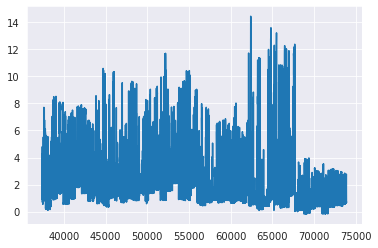

In [39]:
plt.plot(final_preds.index,final_preds['Production'])

In [40]:
final_preds.to_csv('Submission_LSTM.csv')

In [41]:
from google.colab import files
files.download('Submission_LSTM.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

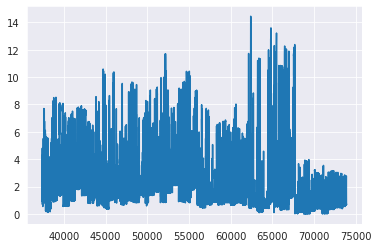

In [42]:
plt.plot(final_preds[final_preds['Production'] > 0])